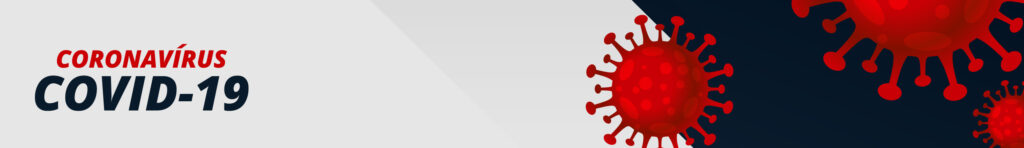

***
***

## Introdução 

Em 2020, a COVID-19 se espalhou por todo o mundo, gerando milhões de mortes e sobrecarregando muito o sistema de saúde dos países, que não foram dimensionados para lidar com uma pandemia dessa escala. 

Os locais de atendimento estão com muitas dificuldades, como a falta de equipamentos e leitos de UTI, profissionais exaustos, e uma fila enorme de pacientes que precisam de atendimento.

Nesse contexto, a equipe de Data Science do Hospital Sírio Libanês propôs o **Call to Action**.

***


## Objetivo

Foi disponibilizado no kaggle um dataset com informações de pacientes contaminados ou com suspeita de COVID-19 que passaram pelo hospital entre 28 de janeiro de 2020 e 16 de abril de 2020. Nesse conjunto de dados, existem informações anonimizadas dos pacientes, com dados demográficos, doenças pré-existentes, resultados de exames e indicadores de sinais vitais dos mesmos. Ao final, há uma indicação se eles foram ou não encaminhados para a UTI. 

O objetivo do projeto é **desenvolver um modelo de Machine Learning que consiga, a partir dos dados fornecidos pelo paciente e pelos exames coletados, prever se aquele paciente vai precisar ou não ser direcionado para a Unidade de Terapia Intensiva (UTI).** É importante apontar que, considerando a sobrecarga nos locais de atendimento, esse diagnóstico deve ser feito da forma mais rápida possível, pois uma agilidade maior na tomada de decisão pode garantir que mais pacientes sejam atendidos.

Outro ponto relevante a ser considerado é que o Sírio Libanês é um hospital de alto padrão que atende em grandes capitais, e dispõe de muitos recursos para realizar quaisquer exames que podem ajudar na detecção da COVID 19. O mesmo não acontece em todas as regiões do país, e muitos desses exames são relativamente complexos e podem estar indisponíveis em locais com menos recursos. Assim, seria interessante desenvolver um segundo modelo, que desconsidera alguns dessas features, que entendo que sejam mais complexas de se obter. O resultado desse modelo terá um desempenho pior que o primeiro, mas poderia ser replicado em locais com menos recursos.

Assim, nesse projeto, serão desenvolvidos 2 modelos:

1) O primeiro vai considerar todos os dados fornecidos pelo Hospital Sirío Libanês, sem restrições.
<br>2) O segundo vai desconsiderar as colunas referentes aos exames referentes ao PCR, Dimer, Lactate, BE, BIC, PCO2. 

***


## Descrição dos dados

No dataset fornecido pelo Sírio Libanês, as features que devem alimentar o modelo de Machine Learning contemplam dados demográficos sobre o paciente, informações sobre doenças anteriores, e resultados dos exames e sinais vitais. A variável "target" é a coluna ICU, que indica se o paciente foi ou não para a UTI, que é o que o modelo tenta prever.
Os dados foram anonimizados e normalizados com o Min Max Scaler para ficarem entre -1 e 1. 

As features são divididas em algumas categorias:

**1. Informações demográficas do paciente** (3 variáveis):
AGE_ABOVE65, AGE_PERCENTIL e GENDER.

**2. Doenças anteriores de pacientes** (agrupadas) (9 variáveis)
DISEASE GROUPING 1 até DISEASE GROUPING 6, HTN, IMMUNOCOMPROMISED, OTHER

**3. Exames de sangue** (36 variáveis): Para cada uma das diferentes medidas listadas abaixo, podem haver 6 variações: mean (média), median (mediana), max (máximo), min (mínimo), diff (max - min) e relative diff (diff/median).

Os exames são:
ALBUMIN, BE_ARTERIAL, BE_VENOUS, BIC_ARTERIAL, BIC_VENOUS, BILLIRUBIN, BLAST, CALCIUM, CREATININ, FFA, GGT, GLUCOSE, HEMATOCRITE, HEMOGLOBIN, INR, LACTATE, LEUKOCYTES, LINFOCITOS, NEUTROPHILES, P02_ARTERIAL, P02_VENOUS, PC02_ARTERIAL, PC02_VENOUS, PCR, PH_ARTERIAL, PH_VENOUS, PLATELETS, POTASSIUM, SAT02_ARTERIAL, SAT02_VENOUS, SODIUM, TGO, TGP, TTPA, UREA, DIMER.

**4. Sinais vitais** (6 variáveis): Para cada uma das diferentes medidas listadas abaixo, podem haver 6 variações: mean (média), median (mediana), max (máximo), min (mínimo), diff (max - min) e relative diff (diff/median).

Os sinais são:
BLOODPRESSURE_DIASTOLIC, BLOODPRESSURE_SISTOLIC, HEART_RATE, RESPIRATORY_RATE, TEMPERATURE, OXYGEN_SATURATION.

***

## Imports e Definições de Funções
***

In [1]:
## Imports

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate,StratifiedKFold, train_test_split
from numpy import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import time
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, fbeta_score, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score , fbeta_score,f1_score
from sklearn.svm import SVC


SEED = 41

In [2]:
def preenche_tabela(dados):
    """
    Preenche os dados nulos, copiando o mesmo valor da janela anterior ou posterior.
    """
    
    features_continuas_colunas = dados.iloc[:, 13:-2].columns
    features_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continuas_colunas].fillna(method='bfill').fillna(method='ffill')
    features_categoricas = dados.iloc[:, :13]
    saida = dados.iloc[:, -2:]
    dados_finais = pd.concat([features_categoricas, features_continuas, saida], ignore_index=True,axis=1)
    dados_finais.columns = dados.columns
    return dados_finais


def prepara_janela(rows):
    """
    Retorna os dados da primeira janela de cada paciente, com o valor de ICU da última.
    """
    
    if(np.any(rows["ICU"])):
        rows.loc[rows["WINDOW"]=="0-2", "ICU"] = 1
    return rows.loc[rows["WINDOW"] == "0-2"]


def agrupa_features_semelhantes(df_corr):
    
    """ No caso dos exames,muitos deles possuem colunas de Minimo, Máximo, Média e Mediana. 
     A função agrupa cada exame. """
    
   
    df_corr['cor_abs'] = df_corr['corr'].apply(abs)
    
    lista_3 = ['_MAX','_MIN']
    lista_4 = ['MEAN', 'DIFF']
    lista_6 = ['DIAN']
    lista_7 = ['_REL']
    lista = []
    for i in df_corr.index:
        if i[-4:] in lista_3:
            lista.append(i[:-4])
        elif i[-4:] in lista_4:
            lista.append(i[:-5])
        elif i[-4:] in lista_6:
            lista.append(i[:-7])
        elif i[-4:] in lista_7:
            lista.append(i[:-9])
        else:
            lista.append(i)
            
    df_corr['novo_nome'] = lista
    df_corr = df_corr.sort_values(['novo_nome', 'cor_abs'], ascending = False)#.drop_duplicates(subset = ['novo_nome'])
    
    return df_corr  
    

def coleta_piores_features(dados):
    
    """
    Baseado no modelo random forrest, seleciona as piores features. 
    São rodados 100 modelos, e em cada um deles, são indicadas as 5 piores features. 
    Ao final, verificamos quantas vezes cada feature ficou entre as piores
    """
    
    np.random.seed(SEED)
    lista_worst_features = []
    lista_worst_features_2 = []
    
    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU"], axis=1)
    
    modelo_random_forrest = RandomForestClassifier(n_estimators = 200)
    
    for i in range(100):
        modelo_random_forrest.fit(x, y)
    
        fi_df = pd.DataFrame({"VARIAVEL": list(x.columns), 
                                "IMPORTANCIA": modelo_random_forrest.feature_importances_})
        
          
        fi_df = fi_df.sort_values("IMPORTANCIA", ascending=False).reset_index(drop = True)
        lista_worst_features.append(fi_df.iloc[-5:,0].to_list())
    
    for i in lista_worst_features:
        for j in i:
            lista_worst_features_2.append(j)
            
    return Counter(lista_worst_features_2)

def roda_modelo_cv(modelo, dados, n_splits, n_repeats, all_results = False):
    
    """
    Roda o modelo utilizando o cross validation, com o RepeatedStratifiedKFold
    """
    print("-----------------------------------------------------------")
    np.random.seed(SEED)
    
    x_columns = dados.columns
    y = dados["ICU"]
    x = dados[x_columns].drop(["ICU"], axis=1)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, stratify=y)
    scoring = {'prec': 'precision',
               'rec': 'recall',
               'acc': 'accuracy',
               'roc':'roc_auc',
               'f1':'f1'
              }    
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
    resultados=cross_validate(modelo, x_train, y_train, cv=cv, scoring=scoring)
    
    modelo.fit(x_train,y_train)
    y_pred = modelo.predict(x_test)
    auc_val = round(roc_auc_score(y_test, y_pred),4)
    
    auc_medio = round(np.mean(resultados['test_roc']),4)
    auc_std = round(np.std(resultados['test_roc']),4)
    
    if all_results == True:
        print("All Scores:")
        print("Acuracy:", round(np.mean(resultados['test_acc']),4))
        print("Recall:", round(np.mean(resultados['test_rec']),4))
        print("Precision:", round(np.mean(resultados['test_prec']),4))
        print("F1-Score:", round(np.mean(resultados['test_f1']),4))
    
    print("O roc auc score do modelo é:", auc_medio, "±", auc_std) 
    ### Considera-se apenas um std, o que garante um intervalo de confiança de ~68%
    
    print("O roc auc score do conjunto de validação é:", auc_val)
    print("-----------------------------------------------------------")
  
    return auc_medio, auc_std, auc_val
    
def roda_random_search(df, n_splits, n_repeats, n_est):
    
    """
    Roda um RandomSearch no Espaço de Parâmetros, e retorna um dataframe com os resultados
    
    """
    tic = time.time()
    np.random.seed(SEED)
    dftotal = df.sample(frac=1).reset_index(drop=True)
    lista_parametros = []

    x_columns = df.columns
    y = dftotal["ICU"]
    x = dftotal[x_columns].drop(["ICU"], axis=1)
    
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)

    busca = RandomizedSearchCV(RandomForestClassifier(), param_distributions=espaco_de_parametros,
                     cv = cv, scoring='roc_auc',  n_iter=n_est)
    busca.fit(x, y)
    resultados = pd.DataFrame(busca.cv_results_)
    resultados = resultados.sort_values('mean_test_score', ascending = False).reset_index(drop = True)
    tac = time.time()
    time_delta = tac - tic
    
    return resultados, time_delta

def cria_melt(dados):
    
    "Aplica a função melt do pandas"
    df = pd.melt(dados, id_vars="ICU", var_name="variavel", value_name="valor")  
    return df


def classifica_intervalo(lista, n_quebras):
    
    """
    Recebe uma lista de valores numéricos, identifica o intervalo sem os outliers, e divide esse intervalo em n sub intervalos.
    É retornada uma lista indicando, para cada valor da lista original, a qual sub intervalo ela pertence.
    
    """
    min_perc = np.percentile(lista, 25)
    max_perc = np.percentile(lista, 75)
    
    median = np.percentile(lista, 50)
    dif = (max_perc-min_perc)/(n_quebras)
    
    outliers_max = median + 1.5*(max_perc-min_perc)
    outliers_min = median - 1.5*(max_perc-min_perc)    
    
    lista_resultado = []
    dif = (outliers_max-outliers_min)/(n_quebras-2)
    
    for a in lista:
        if a < outliers_min:
            lista_resultado.append(1)
        
        for num in range(n_quebras-2):
            if (a >= num*dif + outliers_min and a < (num+1)*dif + outliers_min):
                lista_resultado.append(num+2)
               
        if a >= outliers_max:
            lista_resultado.append(num+2)
    return lista_resultado
    

def inclui_agrupamento(dados, variavel, n_quebras, delete = False):
    
    """
    Modifica o dataframe, incluindo o agrupamento de uma determinada variável, sendo esse agrupamento obtido
    através da função "classifica intervalo".
    """
    
    nome_variavel = str(variavel)+"_PERCENTIL"  
   
    dados[nome_variavel] = classifica_intervalo(dados[variavel].to_list(), n_quebras)
   
    if delete == True:
        dados.drop([variavel], axis = 1, inplace = True)
   
    return dados


In [3]:
## Leitura dos dados

dados_sirio = pd.read_excel("https://github.com/alura-cursos/covid-19-clinical/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
display(dados_sirio.head())

print("O dataset original possui {} linhas e {} colunas, com {} usuários únicos.".format(dados_sirio.shape[0],dados_sirio.shape[1], dados_sirio['PATIENT_VISIT_IDENTIFIER'].nunique()))


,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.238095,-0.818182,-0.389967,0.407558,-0.230462,0.096774,-0.242282,-0.814433,ABOVE_12,1


O dataset original possui 1925 linhas e 231 colunas, com 385 usuários únicos.


O motivo de existirem mais linhas que pacientes, cada registro retorna os dados de cada paciente em uma determinada janela de tempo. Essas janelas são: de 0 a 2 horas, 2 a 4, 4 a 6, 6 a 12, ou mais de 12 horas. Assim, um mesmo paciente pode aparecer em até 6 linhas diferentes, dependendo de quanto tempo ele ficar no hospital, e cada uma delas vai mostrar os dados dos exames naquela janela de tempo. O período a que aquela linha se refere pode ser observada na coluna "WINDOW".

Para o modelo de machine learning, há um prejuízo ao trabalharmos com vários registros por usuário, pois muitas das valores das features seriam repetidas entre uma linha e outra, como por exemplo a idade, genero e doenças pré-existentes. Sem contar que boa parte dos exames podem não ser coletados em todas essas janelas, o que também faria com que os dados fossem repetidos. Isso faz com que o modelo "decorasse" esses valores, e acertassem na previsão do conjunto de teste sem realmente ter aprendido os padrões da forma desejada.

Além disso, a proposta é tentar prever o quanto antes se o usuário vai ser encaminhado para a UTI ou não, para otimizar os recursos dos centros de saúde, e garantir que o máximo de pessoas sejam atendidas. Assim, **faremos um tratamento no dataset para trazer apenas os dados da primeira janela de permanência dos pacientes (0h a 2h), exceto pela variável "ICU"**, que indica se ele foi para a UTI ou não. Nesse caso, o dataset terá o resultado desse campo para a última janela do paciente. 

Por exemplo: caso um paciente fique 5 horas no hospital, e seja internado somente na última janela, retornaremos os resultados dos exames dele da primeira janela, e no campo ICU, o valor será 1 (True).

---

## Preparação e Limpeza dos Dados
***
### Pré Processamento

Realizando as transformações no dataset, para garantir que tenha 1 linha por usuário. Para o tratamento dos dados nulos, são coletas as mesmas informações daquele paciente na janela vizinha.

In [4]:
dados_limpos = preenche_tabela(dados_sirio)
a_remover = dados_limpos.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos = dados_limpos.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos = dados_limpos.dropna()

dados_limpos = dados_limpos.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepara_janela)

display(dados_limpos.head())
print("O dataset novo possui {} linhas e {} colunas.".format(dados_limpos.shape[0],dados_limpos.shape[1], dados_limpos['PATIENT_VISIT_IDENTIFIER'].nunique()))

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0
5,25,5,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0-2,0


O dataset novo possui 352 linhas e 231 colunas.


### Alterações Iniciais

• Remoção das colunas WINDOW e PATIENT_VISIT_IDENTIFIER, que serão inúteis para o modelo.<br>
• Transformação dos dados de AGE PERCENTIL em numéricos. <br>
• Transformação dos dados de Genero para categóricos

In [5]:
# Drop columns
dados_limpos = dados_limpos.drop(['WINDOW','PATIENT_VISIT_IDENTIFIER'] , axis = 1)

# Cast AGE Percentil to Int
dados_limpos['AGE_PERCENTIL'] = dados_limpos['AGE_PERCENTIL'].str.replace('th','')
dados_limpos['AGE_PERCENTIL'] = dados_limpos['AGE_PERCENTIL'].str.replace('Above 90','100')
dados_limpos['AGE_PERCENTIL'] = dados_limpos['AGE_PERCENTIL'].astype(int)

### Change Gender type to category
dados_limpos.GENDER = dados_limpos.GENDER.astype('category')

### Selecionando um modelo base

Serão testados alguns modelos, com alterações mínimas nos hiperparâmetros, a fim de entender quais deles vão performar melhor na previsão. A partir da escolha de um modelo base, utilizaremos sempre esse modelo para balizar as mudanças no dataset.

In [6]:
## Testando diversos modelos diferentes

## Regressão Logística

print("Regressão Logística")
modelo_reg_log = LogisticRegression(max_iter=10000)
media,std, auc_val = roda_modelo_cv(modelo_reg_log, dados_limpos, 10, 30)

## Adaboost

modelo_adb = AdaBoostClassifier(n_estimators=200)
print("Ada Boost")
media, std, auc_val = roda_modelo_cv(modelo_adb, dados_limpos, 10, 30)

## SVC 

print("SVC")
modelo_svc = SVC()
media, std, auc_val = roda_modelo_cv(modelo_svc, dados_limpos, 10, 30)

## Gradient Boosting

print("Gradient Boosting")
modelo_gboost = GradientBoostingClassifier(n_estimators = 200)
media, std, auc_val = roda_modelo_cv(modelo_gboost, dados_limpos, 10, 30)

## Decision Tree
print("Decision Tree Classifier")
decision_tree = DecisionTreeClassifier()
media, std, auc_val= roda_modelo_cv(decision_tree, dados_limpos, 10, 30)

## RF
modelo_random_forrest = RandomForestClassifier(n_estimators = 200)
print("Random Forrest")
media_baseline, std_baseline, auc_val_baseline = roda_modelo_cv(modelo_random_forrest, dados_limpos, 10, 30)

Regressão Logística
-----------------------------------------------------------
O roc auc score do modelo é: 0.7624 ± 0.0945
O roc auc score do conjunto de validação é: 0.7213
-----------------------------------------------------------
Ada Boost
-----------------------------------------------------------
O roc auc score do modelo é: 0.718 ± 0.095
O roc auc score do conjunto de validação é: 0.689
-----------------------------------------------------------
SVC
-----------------------------------------------------------
O roc auc score do modelo é: 0.7101 ± 0.104
O roc auc score do conjunto de validação é: 0.6878
-----------------------------------------------------------
Gradient Boosting
-----------------------------------------------------------
O roc auc score do modelo é: 0.7696 ± 0.0933
O roc auc score do conjunto de validação é: 0.7037
-----------------------------------------------------------
Decision Tree Classifier
-----------------------------------------------------------
O r

O Modelo Random Forrest teve a melhor performance, com o roc auc score inicial de 0.7816. Assim, será nosso modelo base. <br> Analisando o desempenho em maiores detalhes:

In [7]:
## RF 
modelo_random_forrest = RandomForestClassifier(n_estimators = 200)
print("Random Forrest")
media_baseline, std_baseline, auc_val_baseline = roda_modelo_cv(modelo_random_forrest, dados_limpos, 10, 30, True)

Random Forrest
-----------------------------------------------------------
All Scores:
Acuracy: 0.7159
Recall: 0.6887
Precision: 0.7044
F1-Score: 0.6897
O roc auc score do modelo é: 0.7816 ± 0.0905
O roc auc score do conjunto de validação é: 0.7592
-----------------------------------------------------------


Os resultados exibidos acima, especialmete os valores de acurácia, recall e precision dão uma visão mais concreta do desempenho do modelo, visto que o roc auc score e o f1 score tem uma interpretação menos imediata.

No nosso contexto, o recall e precision terão um balanço muito importante: <br>

• O **RECALL** mede, **dentre as pessoas que precisaram ser internadas, quantas delas o modelo conseguiu prever corretamente**.
<br>
• O **PRECISION** mede, **dentre as pessoas que o modelo apontou que seriam encaminhados para a UTI, quantas realmente foram.**
 

A primeira interpretação é que o recall é muito mais importante que o precision no âmbito médico, pois de fato, **um valor de recall baixo, indica que muitas pessoas que precisariam de UTI podem estar sendo liberadas, o que pode trazer consequências muito graves para a saúde daqueles indivíduos.** <br>

Por outro lado, **um modelo que privilegia muito o recall em detrimento do precision, significa que muitas pessoas estariam indo para a UTI além do necessário.** O que é péssimo, pensando em um contexto mais abrangente, pois já existe uma sobrecarga enorme do sistema de saúde, e em muitas situações, há uma falta de leitos. Dessa forma, **um precision alto, ajudaria a otimizar os recursos, e garantir que os leitos sejam destinados a atender somente pessoas com a real necessidade de internação.**

Assim, dependendo do contexto e da taxa de ocupação do ponto de atendimento, **é interessante que haja a alteração do  threshold do modelo, para privilegiar ou o precision ou o recall.** Em uma situação que existam muitos leitos disponíveis na unidade de atendimento, o threshold poderia ser levemente reduzido, para aumentar o recall. Por outro lado, em um contexto que haja um déficit de leitos, talvez seja necessário aumentar o threshold para garantir que os leitos existentes sejam utilizados da melhor forma possível. 

Por isso, apesar de ter uma interpretação mais complexa, **o roc auc score será a métrica acompanhada com maior atenção**. É um indicador que calcula a robustez do modelo de forma mais ampla, e uma otimização dele garante o melhor desempenho considerando esse balanço entre precision e recall.

### Removendo variáveis prejudiciais

Para o modelo de Machine Learning, convém reduzir ao máximo o número de variáveis que não se relacionam bem com a variável target ou que possuem alta correlação entre si, pois podem prejudicar o modelo tanto na capacidade preditiva, quanto no ponto de vista computacional.

#### Removendo features com uma correlação nula em relação a variável target.

Analisando a correlação das variáveis em relação ao target, muitas delas possuem um valor nulo, e serão removidas, por prejudicarem o modelo.

In [8]:
# Criação de um dataframe com as correlações das variáveis em relação ao target
df_corr = pd.DataFrame(dados_limpos.corr()['ICU']).sort_values(by = 'ICU', ascending = False)
df_corr.columns = ['corr']

display(df_corr.head())
# Identificação das variáveis com correlação nula
columns_to_drop_corr_null = df_corr[df_corr['corr'].isnull()].index
print(columns_to_drop_corr_null)
print("Existem", len(columns_to_drop_corr_null), "features com valor nulo de correlação com ICU, que foram removidas.")

# Exclusão das mesmas
dados_limpos = dados_limpos.drop(columns_to_drop_corr_null, axis = 1)
df_corr = df_corr.drop(columns_to_drop_corr_null)

,corr
ICU,1.000000
AGE_PERCENTIL,0.351071
PCR_MAX,0.296455
PCR_MIN,0.296455
PCR_MEAN,0.296455


Index(['ALBUMIN_DIFF', 'BE_ARTERIAL_DIFF', 'BE_VENOUS_DIFF',
       'BIC_ARTERIAL_DIFF', 'BIC_VENOUS_DIFF', 'BILLIRUBIN_DIFF', 'BLAST_DIFF',
       'CALCIUM_DIFF', 'CREATININ_DIFF', 'FFA_DIFF', 'GGT_DIFF',
       'GLUCOSE_DIFF', 'HEMATOCRITE_DIFF', 'HEMOGLOBIN_DIFF', 'INR_DIFF',
       'LACTATE_DIFF', 'LEUKOCYTES_DIFF', 'LINFOCITOS_DIFF',
       'NEUTROPHILES_DIFF', 'P02_ARTERIAL_DIFF', 'P02_VENOUS_DIFF',
       'PC02_ARTERIAL_DIFF', 'PC02_VENOUS_DIFF', 'PCR_DIFF',
       'PH_ARTERIAL_DIFF', 'PH_VENOUS_DIFF', 'PLATELETS_DIFF',
       'POTASSIUM_DIFF', 'SAT02_ARTERIAL_DIFF', 'SAT02_VENOUS_DIFF',
       'SODIUM_DIFF', 'TGO_DIFF', 'TGP_DIFF', 'TTPA_DIFF', 'UREA_DIFF',
       'DIMER_DIFF'],
      dtype='object')
Existem 36 features com valor nulo de correlação com ICU, que foram removidas.


#### Selecionando apenas 1 registro por exame/sinal vital

Ao observar o dataset, notamos que muitas colunas podem se referir ao mesmo tipo de exame ou sinal vital. Podem haver até 6 formas de exibir o resultado: mean (média), median (mediana), max (máximo), min (mínimo), diff (max - min) e relative diff (diff/median). Essas variáveis, como esperado, tem uma correlação alta entre si, como mostrado abaixo:

Amostra do dataframe:


,,ALBUMIN_MAX,ALBUMIN_MEAN,ALBUMIN_MEDIAN,ALBUMIN_MIN,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,
0,0,0.605263,0.605263,0.605263,0.605263,1
2,10,0.605263,0.605263,0.605263,0.605263,1
3,15,-0.263158,-0.263158,-0.263158,-0.263158,0
4,20,0.605263,0.605263,0.605263,0.605263,0
5,25,0.605263,0.605263,0.605263,0.605263,0


Correlação entre as variáveis:


,ALBUMIN_MAX,ALBUMIN_MEAN,ALBUMIN_MEDIAN,ALBUMIN_MIN
ALBUMIN_MAX,1.0,1.0,1.0,1.0
ALBUMIN_MEAN,1.0,1.0,1.0,1.0
ALBUMIN_MEDIAN,1.0,1.0,1.0,1.0
ALBUMIN_MIN,1.0,1.0,1.0,1.0


ViolinPlot:


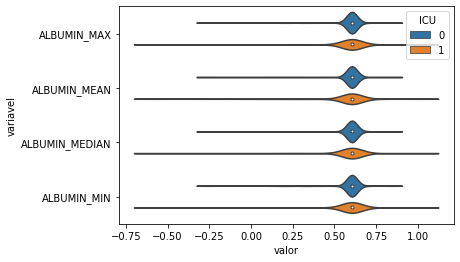

In [9]:
print("Amostra do dataframe:")
display(dados_limpos[['ALBUMIN_MAX','ALBUMIN_MEAN','ALBUMIN_MEDIAN','ALBUMIN_MIN','ICU']].head())

print("Correlação entre as variáveis:")
display(dados_limpos[['ALBUMIN_MAX','ALBUMIN_MEAN','ALBUMIN_MEDIAN','ALBUMIN_MIN']].corr())

print("ViolinPlot:")
dados_alb = dados_limpos[['ALBUMIN_MAX','ALBUMIN_MEAN','ALBUMIN_MEDIAN','ALBUMIN_MIN','ICU']]
dados_alb = cria_melt(dados_alb)
sns.violinplot(dados = dados_alb, y = dados_alb['variavel'], x = dados_alb['valor'], hue = dados_alb['ICU']);


Por possuirem uma alta correlação, várias delas **são redundantes para o modelo e serão removidas**, mantendo somente 1. A variável escolhida para cada exame será aquela com a maior correlação com a variável target. Faremos uma exceção nesse método para 4 features específicas, que será escolhido manualmente. O motivo disso será explicado na etapa de criação de novas features.

In [10]:
# Agrupa as variáveis referentes ao mesmo exame/sinal vital
df_corr_agrupado = agrupa_features_semelhantes(df_corr)

# Alteração manual para incluir as médias desses exames presenes na lista "features_manuais".
features_manuais = ['NEUTROPHILES','LINFOCITOS', 'BLOODPRESSURE_SISTOLIC', 'BLOODPRESSURE_DIASTOLIC']
df_corr_agrupado = df_corr_agrupado.query("novo_nome not in @features_manuais")

# Remoção das features indesejadas
df_corr_agrupado = df_corr_agrupado.drop_duplicates(subset = ['novo_nome'])
columns_to_keep = df_corr_agrupado.index.to_list()
for ind in ["GENDER", "BLOODPRESSURE_SISTOLIC_MEAN", "BLOODPRESSURE_DIASTOLIC_MEAN", "NEUTROPHILES_MEAN", "LINFOCITOS_MEAN"]:
    columns_to_keep.append(ind)
dados_limpos = dados_limpos[columns_to_keep]
print("Após a nova limpeza, o dataset ficou com", dados_limpos.shape[1], "colunas.")


Após a nova limpeza, o dataset ficou com 55 colunas.


#### Removendo outras variáveis

O modelo random forrest possui um atributo "feature importance", que identifica os atributos mais importantes para a tomada de decisão do modelo. Foi criada uma função, onde foi coletada as 5 piores features em 100 iterações diferentes. O resultado é o seguinte:

In [11]:
coleta_piores_features(dados_limpos)

Counter({'P02_ARTERIAL_MEDIAN': 28,
         'PH_ARTERIAL_MAX': 63,
         'SAT02_ARTERIAL_MEDIAN': 92,
         'BLAST_MIN': 100,
         'BE_ARTERIAL_MAX': 100,
         'PC02_ARTERIAL_MEAN': 21,
         'DISEASE GROUPING 4': 14,
         'DISEASE GROUPING 2': 40,
         'BIC_ARTERIAL_MEAN': 39,
         'DISEASE GROUPING 1': 2,
         'DISEASE GROUPING 6': 1})

As features "BLAST_MIN", "BE_ARTERIAL_MAX" e "SAT02_ARTERIAL_MEDIAN" tiveram um desempenho muito pior que as demais.
No entanto, ao tentar remover 1, 2 ou 3 delas, não houve um benefício para o modelo. Portanto, elas serão mantidas.

#### Nova performance do Modelo Base

In [12]:
print("Resultado do Random Forrest após a remoção das piores features:")
modelo_random_forrest = RandomForestClassifier(n_estimators = 200)
media_1, std_1, auc_val_1 = roda_modelo_cv(modelo_random_forrest, dados_limpos, 10, 3)


Resultado do Random Forrest após a remoção das piores features:
-----------------------------------------------------------
O roc auc score do modelo é: 0.7887 ± 0.0845
O roc auc score do conjunto de validação é: 0.7388
-----------------------------------------------------------


## Análise Exploratória
***

### Análise das informações demográficas dos pacientes

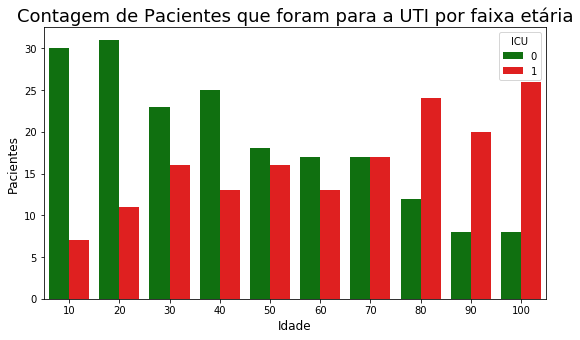

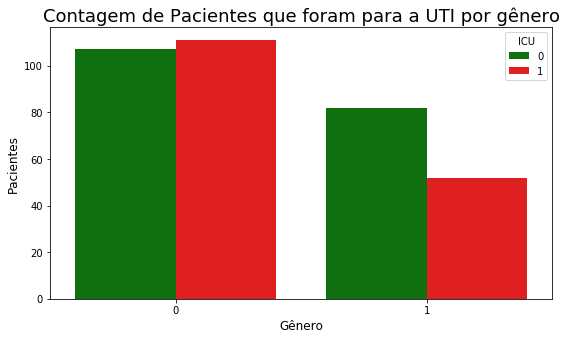

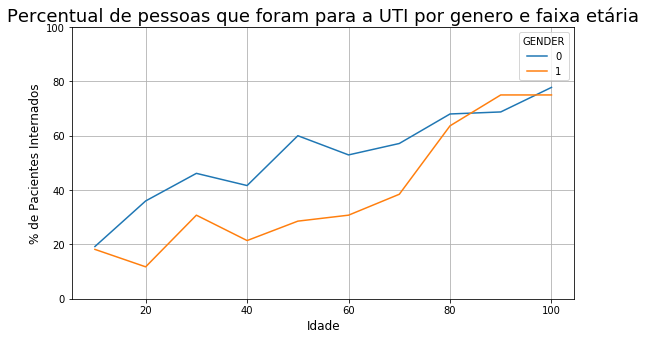

In [13]:
## Grafico 1 
df_idade = dados_limpos.groupby(["AGE_PERCENTIL",'ICU']).agg(['count'])['UREA_MEAN'].reset_index()

plt.figure(figsize = (9,5))
sns.barplot(x='AGE_PERCENTIL', y='count', data = df_idade, hue = 'ICU', palette = ['green','red'])
plt.xlabel('Idade', fontsize=12)
plt.ylabel('Pacientes', fontsize=12)
plt.title("Contagem de Pacientes que foram para a UTI por faixa etária", fontsize=18);

## Grafico 2
df_genero = dados_limpos.groupby(["GENDER",'ICU']).agg(['count'])['UREA_MEAN'].reset_index()

plt.figure(figsize = (9,5))
sns.barplot(x='GENDER', y='count',data = df_genero, hue = 'ICU', palette = ['green','red'])
plt.xlabel('Gênero', fontsize=12)
plt.ylabel('Pacientes', fontsize=12)
plt.title("Contagem de Pacientes que foram para a UTI por gênero", fontsize=18);


## Grafico 3 
df_idade_genero = dados_limpos.groupby(["AGE_PERCENTIL","GENDER",'ICU']).agg(['count'])['UREA_MEAN'].reset_index()
df_idade_genero["percentual"] = df_idade_genero['count']/df_idade_genero.groupby(['AGE_PERCENTIL','GENDER'])['count'].transform('sum').round(1)*100
df_idade_genero.query("ICU == 1")

plt.figure(figsize = (9,5))
sns.lineplot(x='AGE_PERCENTIL', y='percentual', data = df_idade_genero.query("ICU == 1"), hue = 'GENDER')
plt.xlabel('Idade', fontsize=12)
plt.ylabel('% de Pacientes Internados', fontsize=12)
plt.grid()
plt.ylim(0,100)
plt.title("Percentual de pessoas que foram para a UTI por genero e faixa etária", fontsize=18);


Os gráficos mostram uma **relação muito clara entre a faixa etária dos pacientes, e a internação deles ou não**. Para os pacientes com menos de 50 anos, há uma chance muito maior de não haver a internação, entre 50 e 80 há um equilíbrio maior, e acima de 80 anos o risco de iternação já é muito mais elevado.

Em relação ao gênero, há uma chance maior de não haver necessidade de internação para o genero 1: Em praticamente todas as faixas etárias, a % de internação se mostrou maior para o gênero 0.

### Dados de Exames e Sinais Vitais

Vamos analisar algumas distribuições dos exames e sinais vitais, comparando as pessoas que foram internados com as que não foram. Serão mostradas 6 exames/sinais vitais com alta correlação (em valores absolutos), 6 de média, e 6 de baixa.

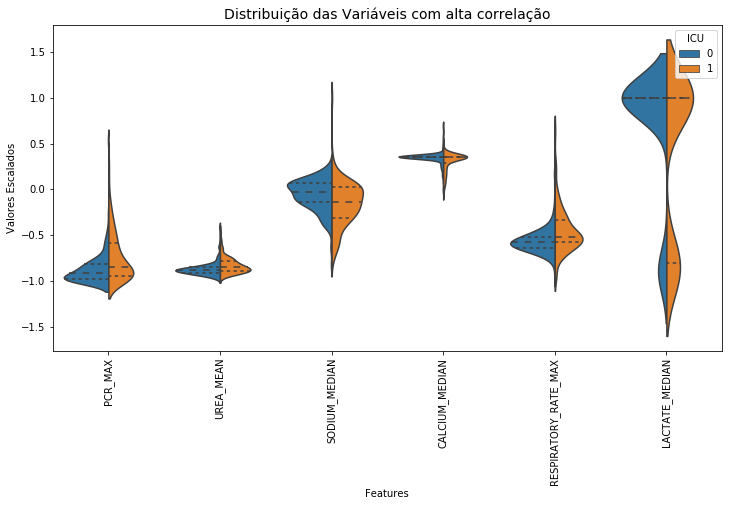

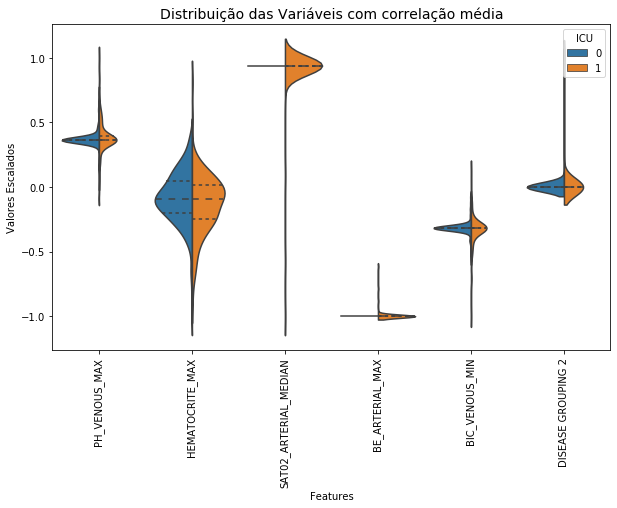

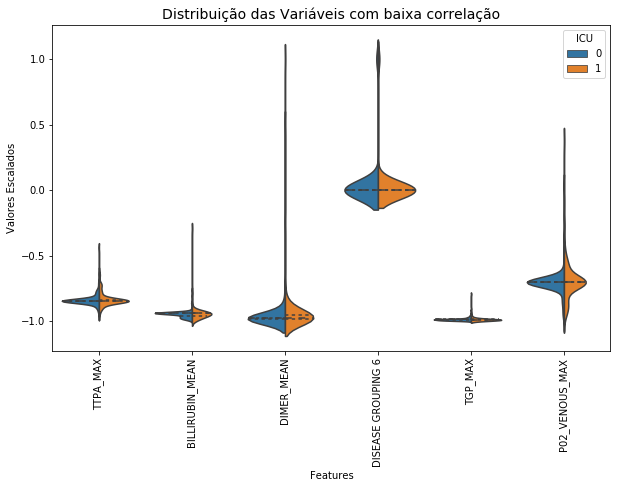

In [14]:
df_corr_agrupado = df_corr_agrupado.sort_values('cor_abs', ascending = False)
df_corr_agrupado.drop(["ICU","AGE_PERCENTIL", 'AGE_ABOVE65'], inplace = True)
df_corr_agrupado.reset_index(inplace = True)


alta_corr = df_corr_agrupado[0:6]['index'].to_list()
media_corr = df_corr_agrupado[20:26]['index'].to_list()
baixa_corr = df_corr_agrupado[-6:]['index'].to_list()

alta_corr.append("ICU")
media_corr.append("ICU")
baixa_corr.append("ICU")

df_alta = cria_melt(dados_limpos[alta_corr])
df_media = cria_melt(dados_limpos[media_corr])
df_baixa = cria_melt(dados_limpos[baixa_corr])

plt.figure(figsize=(12,6))
ax = sns.violinplot(x= 'variavel', y = 'valor', hue = 'ICU', inner="quartile", split=True, data = df_alta)
plt.title('Distribuição das Variáveis com alta correlação', fontsize=14)
plt.xlabel('Features')
plt.ylabel('Valores Escalados')
plt.xticks(rotation=90)
plt.show()

#idade_UTI_gene

plt.figure(figsize=(10,6))
ax = sns.violinplot(x= 'variavel', y = 'valor', hue = 'ICU', inner="quartile", split=True, data = df_media)
plt.title('Distribuição das Variáveis com correlação média', fontsize=14)
plt.xlabel('Features')
plt.ylabel('Valores Escalados')
plt.xticks(rotation=90)
plt.show()

#idade_UTI_gene

plt.figure(figsize=(10,6))
ax = sns.violinplot(x= 'variavel', y = 'valor', hue = 'ICU', inner="quartile", split=True, data = df_baixa)
plt.title('Distribuição das Variáveis com baixa correlação', fontsize=14)
plt.xlabel('Features')
plt.ylabel('Valores Escalados')
plt.xticks(rotation=90)

plt.show()

#idade_UTI_gene

Fica claro que quanto mais forte é o índice de correlação, maior é a assimetria entre quem foi ou não para a UTI. Por consequência, mais importante tende a ser aquela feature para o modelo.

## Feature Engineering
***

### Criação de Novas Variáveis

A equipe de data science do Sírio Libanês propôs a criação de 2 novas variáveis: "BLOODPRESSURE_ARTERIAL_MEAN" e "NEUTROPHILES/LINFOCITOS".

In [15]:
dados_limpos["BLOODPRESSURE_ARTERIAL_MEAN"] = (dados_limpos['BLOODPRESSURE_SISTOLIC_MEAN'] + 2*dados_limpos
['BLOODPRESSURE_DIASTOLIC_MEAN'])/3

dados_limpos["NEUTROPHILES/LINFOCITOS"] = dados_limpos['NEUTROPHILES_MEAN']/dados_limpos['LINFOCITOS_MEAN']
dados_limpos = dados_limpos.drop(['LINFOCITOS_MEAN','NEUTROPHILES_MEAN','BLOODPRESSURE_SISTOLIC_MEAN'], axis = 1)

print("Resultados do Random Forrest após a inclusão das features sugeridas pelo Sírio")
media_2, std_2, auc_val_2 = roda_modelo_cv(modelo_random_forrest, dados_limpos, 10, 30)

Resultados do Random Forrest após a inclusão das features sugeridas pelo Sírio
-----------------------------------------------------------
O roc auc score do modelo é: 0.8016 ± 0.085
O roc auc score do conjunto de validação é: 0.7709
-----------------------------------------------------------


A inclusão delas, associadas a exclusão de algumas features que as originaram, geraram uma melhora significativa no modelo. 
Vamos tentar propor algumas alterações para melhorar a capacidade preditiva. Serão analisadas somente as principais variáveis.

#### Análise da Importância das features

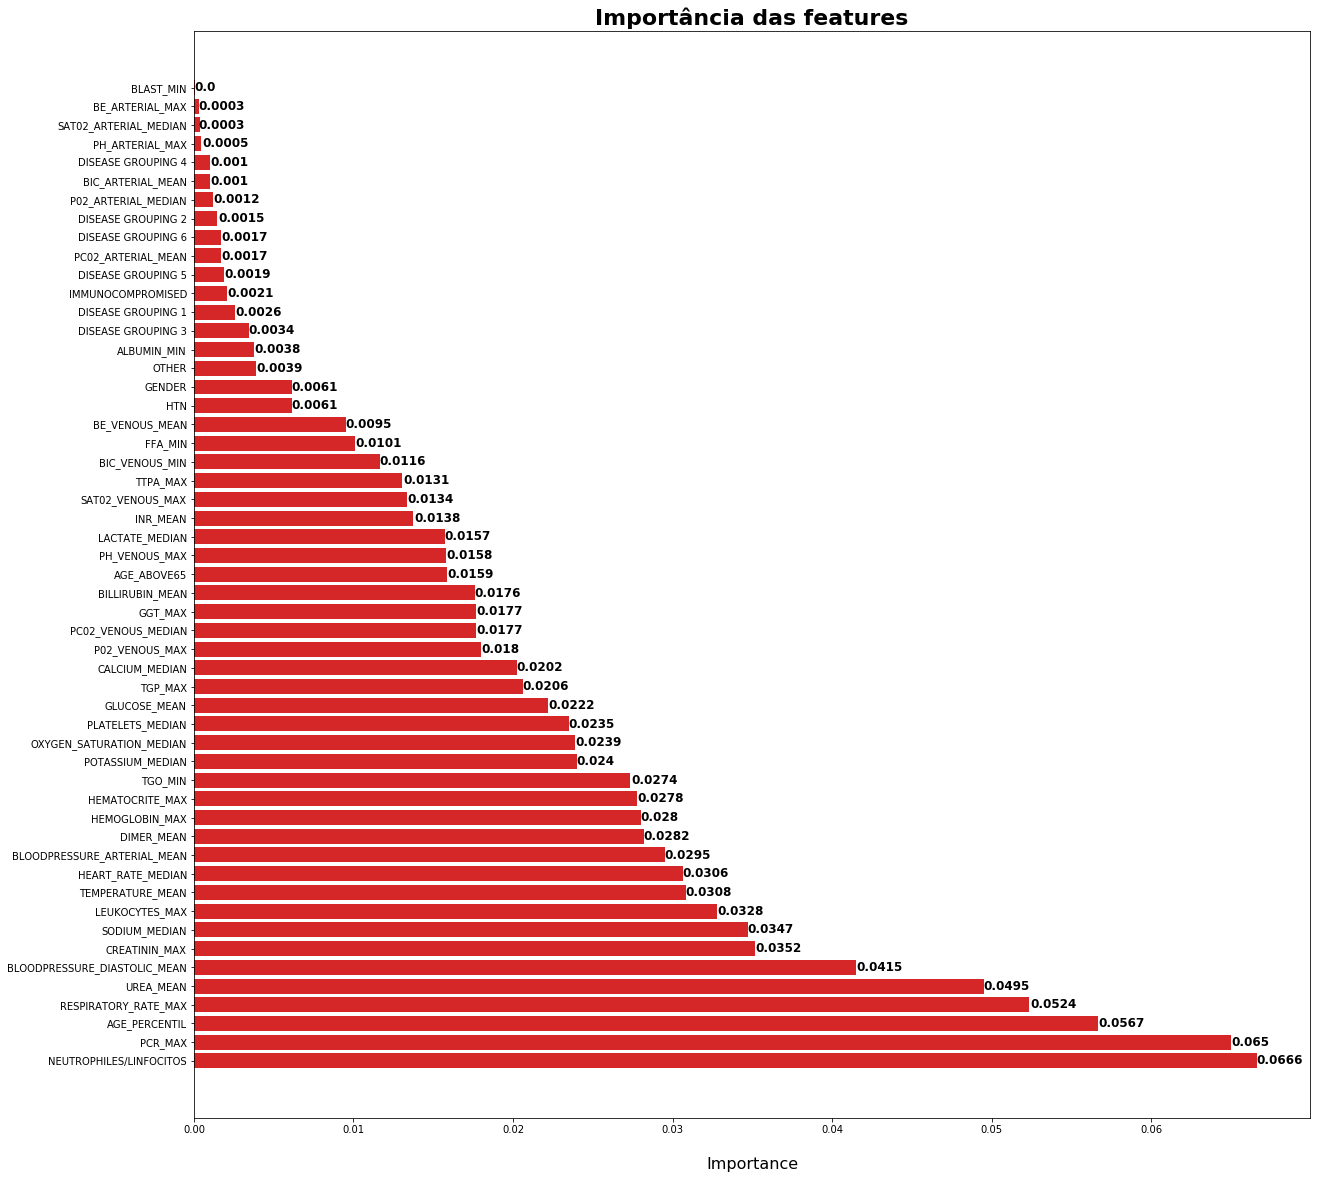

In [16]:
np.random.seed(SEED)

x_columns = dados_limpos.columns
y = dados_limpos["ICU"]
x = dados_limpos[x_columns].drop(["ICU"], axis=1)
    
modelo_random_forrest = RandomForestClassifier(n_estimators = 200)
modelo_random_forrest.fit(x, y)

fi_df = pd.DataFrame({"VARIAVEL": list(x.columns), 
                                "IMPORTANCIA": modelo_random_forrest.feature_importances_})
        
fi_df = fi_df.sort_values("IMPORTANCIA", ascending=False).reset_index(drop = True)

plt.figure(figsize=(20, 20))
plt.barh(y=fi_df['VARIAVEL'], width=fi_df['IMPORTANCIA'], color ="tab:red")
plt.title('Importância das features', fontsize=22, fontweight='bold')
plt.xlabel('Importance', fontsize=16, labelpad=22)

for index, value in enumerate(fi_df["IMPORTANCIA"].round(4)):
    plt.text(value, index, str(value), color='black', fontweight="bold", fontsize=12, verticalalignment='center')

plt.show()

#### Descrição do Processo

Na criação de novas features, um método que pode gerar bons resultados é agrupar os dados de uma forma que os grupos se comportem de forma similar em relação a variável target. <br> 
A função "classifica intervalo" recebe uma lista com os valores numéricos de uma determinada feature, e identifica em qual "agrupamento" aquele dado está. Essa divisão é feita da seguinte forma: A partir de uma lista de valores, é identificado um intervalo onde a maioria dos dados estão (são excluindo outliers). Posteriormente, é feita a divisão dele em n-2 quebras (os outros 2 são referentes aos outliers dos dois extremos). O resultado pode ser visto visualmente abaixo, para as 5 principais features.

<Figure size 864x432 with 0 Axes>

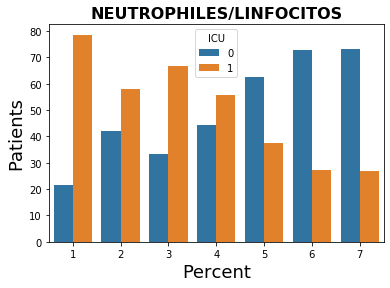

<Figure size 864x432 with 0 Axes>

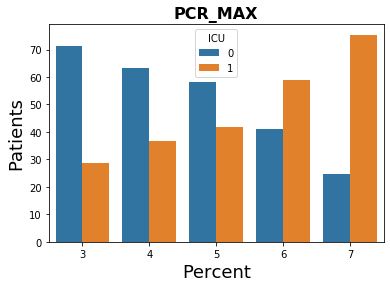

<Figure size 864x432 with 0 Axes>

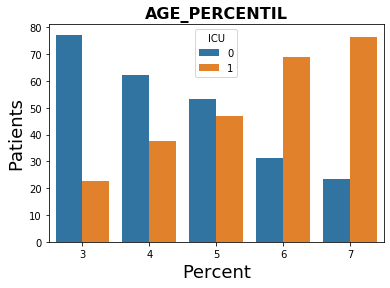

<Figure size 864x432 with 0 Axes>

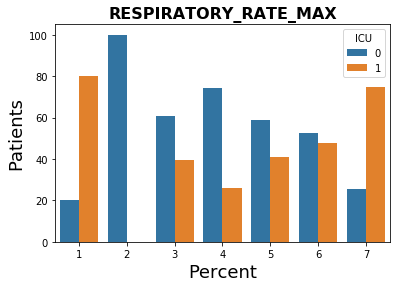

In [17]:
n_splits = 8
for ind in fi_df['VARIAVEL'][:4]:
    dados_limpos['feature_pct'] = classifica_intervalo(dados_limpos[ind].to_list(),n_splits)
    df_agrupado = dados_limpos.groupby(['feature_pct','ICU']).count()[ind].reset_index()
    df_agrupado["perc"] = df_agrupado[ind]/df_agrupado.groupby(['feature_pct'])[ind].transform('sum').round(1)*100
    plt.figure(figsize=(12,6))
     
    fig, ax = plt.subplots()
    sns.barplot(data=df_agrupado, x="feature_pct", y='perc', hue="ICU")  
    ax.set_title(ind, fontsize=16, fontweight="bold")
    ax.set_xlabel("Percent", fontsize=18)  
    ax.set_ylabel("Patients", fontsize=18)
    ax;

dados_limpos.drop(['feature_pct'], axis = 1, inplace = True)


A partir dessa ideia, foram feitos uma serie de testes para identificar quais quebras melhoram o desempenho do modelo. Ao final, foram feitas 2 alterações no dataset original.

In [18]:
### Agrupando idades semelhantes

dict_AGE = {
    10: 1,
    20: 1,
    30: 1,
    40: 1,
    50: 2,
    60: 2,
    70: 2,
    80: 3,
    90: 3,
    100: 3
}

dados_limpos['AGE_AGRUPADO'] = dados_limpos['AGE_PERCENTIL'].map(dict_AGE)
dados_limpos = dados_limpos.drop("AGE_ABOVE65", axis = 1)

# agrupando indivíduos com "Respiratory Rate Max" semelhante
inclui_agrupamento(dados_limpos,'RESPIRATORY_RATE_MAX',5)

,,UREA_MEAN,TTPA_MAX,TGP_MAX,TGO_MIN,TEMPERATURE_MEAN,SODIUM_MEDIAN,SAT02_VENOUS_MAX,SAT02_ARTERIAL_MEDIAN,RESPIRATORY_RATE_MAX,POTASSIUM_MEDIAN,...,BE_VENOUS_MEAN,BE_ARTERIAL_MAX,ALBUMIN_MIN,AGE_PERCENTIL,GENDER,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_ARTERIAL_MEAN,NEUTROPHILES/LINFOCITOS,AGE_AGRUPADO,RESPIRATORY_RATE_MAX_PERCENTIL
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,
0,0,-0.836145,-0.825613,-0.990854,-0.997201,-0.285714,-0.028571,0.345679,0.939394,-0.636364,-0.518519,...,-1.000000,-1.0,0.605263,60,0,0.086420,-0.019310,0.949515,2,3
2,10,-0.836145,-0.846633,-0.986662,-0.995428,0.357143,0.085714,0.345679,0.939394,-0.575758,-0.703704,...,-1.000000,-1.0,0.605263,10,0,-0.489712,-0.554965,0.454450,1,3
3,15,-0.937349,-0.846633,-0.956555,-0.989549,-0.285714,0.200000,0.580247,0.939394,-0.515152,-0.777778,...,-1.000000,-1.0,-0.263158,40,1,0.012346,-0.114846,0.938541,1,3
4,20,-0.903614,-0.846633,-0.991235,-0.998507,0.285714,0.142857,0.345679,0.939394,-0.575758,-0.592593,...,-1.000000,-1.0,0.605263,10,0,0.333333,0.170940,1.267746,1,3
5,25,-0.884337,-0.846633,-0.988948,-0.997947,-0.196429,0.085714,0.345679,0.939394,-0.575758,-0.666667,...,-1.000000,-1.0,0.605263,10,0,-0.037037,-0.204179,2.487410,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,1900,-0.860241,-0.629428,-0.981326,-0.925725,0.142857,-0.428571,0.345679,0.939394,-0.515152,-0.629630,...,-1.000000,-1.0,-0.578947,40,1,-0.160494,-0.337765,0.851571,1,3
381,1905,-0.855422,-0.846633,-0.995808,-0.998507,-0.059524,-0.314286,0.345679,0.939394,-0.515152,-0.518519,...,-1.000000,-1.0,0.605263,100,0,-0.407407,-0.502374,0.905741,3,3
382,1910,-0.787952,-0.846633,-0.986662,-0.995428,-0.071429,-0.085714,0.345679,0.939394,-0.515152,-0.407407,...,-1.000000,-1.0,0.605263,50,0,0.012346,-0.119975,0.894205,2,3


#### Novo desempenho dos principais modelos após alterações

In [19]:
## Generating a baseline model to see how our changes are improving

## RF
modelo_random_forrest = RandomForestClassifier(n_estimators = 200)
print("Random Forrest")
media_3, std_3, auc_val_3 = roda_modelo_cv(modelo_random_forrest, dados_limpos, 10, 30)

## Regressão Logística

print("Regressão Logística")
modelo_reg_log = LogisticRegression(max_iter=10000)
media,std,auc_val = roda_modelo_cv(modelo_reg_log, dados_limpos, 10, 30)

## Gradient Boosting

print("Gradient Boosting")
modelo_gboost = GradientBoostingClassifier(n_estimators = 200)
media, std,auc_val = roda_modelo_cv(modelo_gboost, dados_limpos, 10, 30)


Random Forrest
-----------------------------------------------------------
O roc auc score do modelo é: 0.813 ± 0.0841
O roc auc score do conjunto de validação é: 0.7972
-----------------------------------------------------------
Regressão Logística
-----------------------------------------------------------
O roc auc score do modelo é: 0.7622 ± 0.0928
O roc auc score do conjunto de validação é: 0.6819
-----------------------------------------------------------
Gradient Boosting
-----------------------------------------------------------
O roc auc score do modelo é: 0.7872 ± 0.0891
O roc auc score do conjunto de validação é: 0.7666
-----------------------------------------------------------


## Otimização dos Hiperparâmetros

Ao final do processo de feature engeneer, vamos rodar um randomsearch por um espaço de parâmetros, para escolher o a configuração que trárá os melhores resultados ao modelo.

In [20]:
espaco_de_parametros = {
    "n_estimators" : [200],
    "max_depth" : [None, 3,4],
    "criterion" : ["gini", "entropy"],
    "max_features" : ["sqrt", "log2"],
    "bootstrap" : [True],
    "min_samples_split" : [2,3,4,5,6,7,8,9,10,12,16,20],
    "min_samples_leaf" : [1,2,3,4,5,6,7]
}

resultados, tempo_percorrido = roda_random_search(dados_limpos, 10,15,75)

display(resultados.head(7))
print("O randomsearch levou", round(tempo_percorrido/60,1), " minutos.")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,...,split143_test_score,split144_test_score,split145_test_score,split146_test_score,split147_test_score,split148_test_score,split149_test_score,mean_test_score,std_test_score,rank_test_score
0,0.346128,0.017951,0.017962,0.002420,200,4,2,log2,None,entropy,...,0.802632,0.881579,0.894737,0.789474,0.700658,0.868421,0.871711,0.823310,0.069072,1
1,0.323467,0.015173,0.017172,0.004622,200,8,1,log2,None,gini,...,0.832237,0.858553,0.871711,0.782895,0.730263,0.851974,0.848684,0.822920,0.072851,2
2,0.375965,0.016314,0.018134,0.003398,200,2,2,sqrt,None,entropy,...,0.776316,0.894737,0.898026,0.792763,0.720395,0.838816,0.855263,0.822320,0.070212,3
3,0.320432,0.022709,0.018385,0.003246,200,12,2,log2,None,gini,...,0.812500,0.855263,0.894737,0.782895,0.703947,0.865132,0.838816,0.822181,0.073102,4
4,0.357146,0.017954,0.018903,0.002976,200,2,2,log2,None,entropy,...,0.812500,0.878289,0.894737,0.812500,0.700658,0.842105,0.848684,0.821951,0.070605,5
5,0.330127,0.017551,0.017395,0.005019,200,16,1,sqrt,None,gini,...,0.812500,0.884868,0.884868,0.786184,0.710526,0.858553,0.855263,0.821895,0.072646,6
6,0.354190,0.016387,0.018775,0.006177,200,2,1,log2,None,entropy,...,0.807566,0.878289,0.898026,0.791118,0.731908,0.855263,0.847039,0.821418,0.071296,7


O randomsearch levou 70.0  minutos.


A partir do resultado gerado, vamos rodar as 5 melhores combinações de parâmetros diferentes, e tentar escolher o que melhor se ajusta, não só no conjunto de teste, como no conjunto de validação também, para evitar a escolha de hiperparâmetros que causam um overfit grande nos dados.

In [21]:
list_par = resultados.params[:5]
i = 1
for par in list_par:
    modelo_random_forrest = RandomForestClassifier(**par)
    print("Conjunto ", i,":", par)
    media, std,auc_val = roda_modelo_cv(modelo_random_forrest, dados_limpos, 10, 30)
    i = i+1

Conjunto  1 : {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True}
-----------------------------------------------------------
O roc auc score do modelo é: 0.8144 ± 0.0847
O roc auc score do conjunto de validação é: 0.7592
-----------------------------------------------------------
Conjunto  2 : {'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'criterion': 'gini', 'bootstrap': True}
-----------------------------------------------------------
O roc auc score do modelo é: 0.813 ± 0.0833
O roc auc score do conjunto de validação é: 0.7898
-----------------------------------------------------------
Conjunto  3 : {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True}
-----------------------------------------------------------
O roc

O processo do random search indicou que alguns hiperparâmetros trazem um resultado melhor em comparação ao modelo sem ajustes. O conjunto 1 retorna um resultado de 0.8144, que é superior ao 0.813 que tinhamos anteriormente. No entanto, o desempenho no conjunto de validação foi muito inferior (0.797 para 0.759). Isso sugere que pode estar havendo um overfit nos dados. O mesmo acontece com outras combinações. 

<br> **Assim, não serão ajustados os hiperparâmetros, e o modelo final terá a configuração default do sklearn, alterando somente o n_estimators.**

In [22]:
print("O resultado final do Random Forrest é:")

modelo_final = RandomForestClassifier(n_estimators = 200)
media_final, std_final,auc_val_final = roda_modelo_cv(modelo_final, dados_limpos, 10, 30, True)

O resultado final do Random Forrest é:
-----------------------------------------------------------
All Scores:
Acuracy: 0.7348
Recall: 0.7185
Precision: 0.7219
F1-Score: 0.7129
O roc auc score do modelo é: 0.813 ± 0.0841
O roc auc score do conjunto de validação é: 0.7972
-----------------------------------------------------------


## Resumo e Conclusões:

### Etapas do Projeto
• **Introdução**
<br>• **Objetivo**
<br>• **Descrição dos Dados**
<br>• **Imports e definição das funções**
<br>• **Preparação e Limpeza dos dados** <br>
&emsp; &emsp; Transformações no dataset original, mantendo 1 linha por paciente <br>
&emsp; &emsp; Alterações iniciais no formatos dos dados<br>
&emsp; &emsp; Seleção do modelo base <font color='red'>(1)</font> <br>
&emsp; &emsp; Remoção das variáveis prejudiciais (correlação nula com o target, e seleção de apenas 1 coluna por exame) <font color='red'>(2)</font>
<br>• **Análise Exploratória** <br>
&emsp; &emsp; Análise das variáveis demográficas <br>
&emsp; &emsp; Análise dos exames/sinais vitais: alta correlação, média correlação e baixa correlação 
<br>• **Feature Engineering**: <br>
&emsp; &emsp; Criação de novas features <font color='red'>(3)</font> e <font color='red'>(4)</font>.
<br>• **Otimização dos Hiperparâmetros** <br>
&emsp; &emsp; Realização do Random Search

### Evolução do Resultado 
Os resultados parciais foram:
<br>
<font color='red'>(1)</font> 0.7816 ± 0.0905 (validação: 0.7592) <br>
<font color='red'>(2)</font> 0.7887 ± 0.0845 (validação: 0.7388)<br>
<font color='red'>(3)</font> 0.8016 ± 0.085 (validação: 0.7709)<br>
<font color='red'>(4)</font> 0.813 ± 0.0841 (validação: 0.7972)

### Conclusões

• O modelo que teve a melhor performance foi o Random Forrest. O gradient search e logistic regression também tiveram um bom desempenho.

• Os dados do PCR MAX, NEUTROPHILES/LONFOCITOS e o AGE PERCENTIL dos pacientes foram as features que mais auxiliaram o modelo na previsão dos resultados

• Apesar do modelo não substituir a avaliação de um médico, ele pode servir como uma segunda opinião valiosa, principalmente considerando que os profissionais de saúde estão trabalhando jornadas muito longas e podem estar mais suscetíveis a cometer erros.


## Desafio Extra: Removendo exames mais complexos

Conforme citado no objetivo do projeto, vamos desenvolver um modelo extra, que desconsidera alguns exames considerados menos acessíveis. A tendência é que esse modelo tenha um desempenho pior do que o primeiro, mas que possa ser aplicado também em locais com poucos recursos. 

Os passos realizados serão muito similares ao desenvolvido no primeiro modelo.

In [23]:
colunas_a_remover = [
'BE_ARTERIAL_DIFF', 'BE_ARTERIAL_MAX','BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MEDIAN',
'BE_ARTERIAL_MIN', 'BE_VENOUS_DIFF','BE_VENOUS_MAX', 'BE_VENOUS_MEAN','BE_VENOUS_MEDIAN','BE_VENOUS_MIN',
'BIC_ARTERIAL_DIFF','BIC_ARTERIAL_MAX','BIC_ARTERIAL_MEAN','BIC_ARTERIAL_MEDIAN','BIC_ARTERIAL_MIN',
'BIC_VENOUS_DIFF','BIC_VENOUS_MAX','BIC_VENOUS_MEAN','BIC_VENOUS_MEDIAN','BIC_VENOUS_MIN',
'DIMER_DIFF','DIMER_MAX','DIMER_MEAN','DIMER_MEDIAN','DIMER_MIN',
'LACTATE_DIFF','LACTATE_MAX','LACTATE_MEAN','LACTATE_MEDIAN','LACTATE_MIN',
'PC02_ARTERIAL_DIFF','PC02_ARTERIAL_MAX','PC02_ARTERIAL_MEAN','PC02_ARTERIAL_MEDIAN','PC02_ARTERIAL_MIN',
'PC02_VENOUS_DIFF','PC02_VENOUS_MAX','PC02_VENOUS_MEAN','PC02_VENOUS_MEDIAN','PC02_VENOUS_MIN',
'PCR_DIFF','PCR_MAX','PCR_MEAN','PCR_MEDIAN','PCR_MIN']


In [24]:
dados_limpos_red = preenche_tabela(dados_sirio)
a_remover = dados_limpos_red.query("WINDOW=='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
dados_limpos_red = dados_limpos_red.query("PATIENT_VISIT_IDENTIFIER not in @a_remover")
dados_limpos_red = dados_limpos_red.dropna()

dados_limpos_red = dados_limpos_red.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepara_janela)

display(dados_limpos_red.head())
print("O dataset novo possui {} linhas e {} colunas.".format(dados_limpos_red.shape[0],dados_limpos_red.shape[1], dados_limpos_red['PATIENT_VISIT_IDENTIFIER'].nunique()))

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,...,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0
5,25,5,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.976190,-0.979798,-0.860870,-0.714460,-0.986481,-1.000000,-0.975891,-0.980129,0-2,0


O dataset novo possui 352 linhas e 231 colunas.


In [25]:
# Drop columns
dados_limpos_red = dados_limpos_red.drop(['WINDOW','PATIENT_VISIT_IDENTIFIER'] , axis = 1)
dados_limpos_red = dados_limpos_red.drop(colunas_a_remover, axis = 1)

# Cast AGE Percentil to Int
dados_limpos_red['AGE_PERCENTIL'] = dados_limpos_red['AGE_PERCENTIL'].str.replace('th','')
dados_limpos_red['AGE_PERCENTIL'] = dados_limpos_red['AGE_PERCENTIL'].str.replace('Above 90','100')
dados_limpos_red['AGE_PERCENTIL'] = dados_limpos_red['AGE_PERCENTIL'].astype(int)

### Change Gender type to category
dados_limpos_red.GENDER = dados_limpos_red.GENDER.astype('category')

In [26]:
## Generating a baseline model to see how our changes are improving

## RF
modelo_random_forrest = RandomForestClassifier(n_estimators = 200)
print("Random Forrest")
media_baseline, std_baseline, auc_val_baseline = roda_modelo_cv(modelo_random_forrest, dados_limpos_red, 10, 30)

## Regressão Logística

print("Regressão Logística")
modelo_reg_log = LogisticRegression(max_iter=10000)
media,std, auc_val = roda_modelo_cv(modelo_reg_log, dados_limpos_red, 10, 30)


## Adaboost
modelo_adb = AdaBoostClassifier(n_estimators=200)
print("Ada Boost")
media, std, auc_val = roda_modelo_cv(modelo_adb, dados_limpos_red, 10, 30)

## SVC 
print("SVC")
modelo_svc = SVC()
media, std, auc_val = roda_modelo_cv(modelo_svc, dados_limpos_red, 10, 30)

## Gradient Boosting
print("Gradient Boosting")
modelo_gboost = GradientBoostingClassifier(n_estimators = 200)
media, std, auc_val = roda_modelo_cv(modelo_gboost, dados_limpos_red, 10, 30)

## Decision Tree
from sklearn.tree import DecisionTreeClassifier
print("Decision Tree Classifier")
decision_tree = DecisionTreeClassifier()
media, std, auc_val= roda_modelo_cv(decision_tree, dados_limpos_red, 10, 30)


Random Forrest
-----------------------------------------------------------
O roc auc score do modelo é: 0.7688 ± 0.0918
O roc auc score do conjunto de validação é: 0.7359
-----------------------------------------------------------
Regressão Logística
-----------------------------------------------------------
O roc auc score do modelo é: 0.7352 ± 0.0968
O roc auc score do conjunto de validação é: 0.7037
-----------------------------------------------------------
Ada Boost
-----------------------------------------------------------
O roc auc score do modelo é: 0.7011 ± 0.1019
O roc auc score do conjunto de validação é: 0.6643
-----------------------------------------------------------
SVC
-----------------------------------------------------------
O roc auc score do modelo é: 0.6989 ± 0.1068
O roc auc score do conjunto de validação é: 0.6878
-----------------------------------------------------------
Gradient Boosting
-----------------------------------------------------------
O roc auc

In [27]:
# Criação de um dataframe com as correlações das variáveis em relação ao target

df_corr = pd.DataFrame(dados_limpos_red.corr()['ICU']).sort_values(by = 'ICU', ascending = False)
df_corr.columns = ['corr']

# Identificação das variáveis com correlação nula
columns_to_drop_corr_null = df_corr[df_corr['corr'].isnull()].index
print(columns_to_drop_corr_null)
print("Existem", len(columns_to_drop_corr_null), "features com valor nulo de correlação com ICU, que foram removidas.")

# Exclusão das mesmas

dados_limpos_red = dados_limpos_red.drop(columns_to_drop_corr_null, axis = 1)
df_corr = df_corr.drop(columns_to_drop_corr_null)

Index(['ALBUMIN_DIFF', 'BILLIRUBIN_DIFF', 'BLAST_DIFF', 'CALCIUM_DIFF',
       'CREATININ_DIFF', 'FFA_DIFF', 'GGT_DIFF', 'GLUCOSE_DIFF',
       'HEMATOCRITE_DIFF', 'HEMOGLOBIN_DIFF', 'INR_DIFF', 'LEUKOCYTES_DIFF',
       'LINFOCITOS_DIFF', 'NEUTROPHILES_DIFF', 'P02_ARTERIAL_DIFF',
       'P02_VENOUS_DIFF', 'PH_ARTERIAL_DIFF', 'PH_VENOUS_DIFF',
       'PLATELETS_DIFF', 'POTASSIUM_DIFF', 'SAT02_ARTERIAL_DIFF',
       'SAT02_VENOUS_DIFF', 'SODIUM_DIFF', 'TGO_DIFF', 'TGP_DIFF', 'TTPA_DIFF',
       'UREA_DIFF'],
      dtype='object')
Existem 27 features com valor nulo de correlação com ICU, que foram removidas.


In [28]:
# Agrupa as variáveis referentes ao mesmo exame/sinal vital
df_corr_agrupado = agrupa_features_semelhantes(df_corr)

# Alteração manual para incluir as médias desses exames presenes na lista "features_manuais".
features_manuais = ['NEUTROPHILES','LINFOCITOS', 'BLOODPRESSURE_SISTOLIC', 'BLOODPRESSURE_DIASTOLIC']
df_corr_agrupado = df_corr_agrupado.query("novo_nome not in @features_manuais")

# Remoção das features indesejadas
df_corr_agrupado = df_corr_agrupado.drop_duplicates(subset = ['novo_nome'])
columns_to_keep = df_corr_agrupado.index.to_list()
for ind in ["GENDER", "BLOODPRESSURE_SISTOLIC_MEAN", "BLOODPRESSURE_DIASTOLIC_MEAN", "NEUTROPHILES_MEAN", "LINFOCITOS_MEAN"]:
    columns_to_keep.append(ind)
dados_limpos_red = dados_limpos_red[columns_to_keep]
print("Após a nova limpeza, o dataset ficou com", dados_limpos_red.shape[1], "colunas.")


Após a nova limpeza, o dataset ficou com 46 colunas.


In [29]:
# com 55 colunas
print("Resultado Random Forrest após a remoção inicial das features")
modelo_random_forrest = RandomForestClassifier(n_estimators = 200)

media, std, auc_val = roda_modelo_cv(modelo_random_forrest, dados_limpos, 10, 30)

Resultado Random Forrest após a remoção inicial das features
-----------------------------------------------------------
O roc auc score do modelo é: 0.813 ± 0.0841
O roc auc score do conjunto de validação é: 0.7972
-----------------------------------------------------------


In [30]:
coleta_piores_features(dados_limpos_red)

Counter({'DISEASE GROUPING 2': 81,
         'P02_ARTERIAL_MIN': 70,
         'DISEASE GROUPING 4': 46,
         'SAT02_ARTERIAL_MAX': 98,
         'BLAST_MEDIAN': 100,
         'PH_ARTERIAL_MAX': 89,
         'DISEASE GROUPING 6': 13,
         'DISEASE GROUPING 1': 3})

Assim como no primeiro modelo, ao identificar as piores features, e tentando remover 1, 2 ou 3 delas, não houve uma melhoria no modelo. Assim, não serão removidas.

In [31]:
dados_limpos_red["BLOODPRESSURE_ARTERIAL_MEAN"] = (dados_limpos_red['BLOODPRESSURE_SISTOLIC_MEAN'] + 2*dados_limpos_red
['BLOODPRESSURE_DIASTOLIC_MEAN'])/3

dados_limpos_red["NEUTROPHILES/LINFOCITOS"] = dados_limpos_red['NEUTROPHILES_MEAN']/dados_limpos_red['LINFOCITOS_MEAN']
dados_limpos_red = dados_limpos_red.drop(['LINFOCITOS_MEAN','NEUTROPHILES_MEAN','BLOODPRESSURE_SISTOLIC_MEAN'], axis = 1)

print("Resultado após as alterações sugeridas pelo sírio")
media, std, auc_val = roda_modelo_cv(modelo_random_forrest, dados_limpos_red, 10, 30)


Resultado após as alterações sugeridas pelo sírio
-----------------------------------------------------------
O roc auc score do modelo é: 0.797 ± 0.0861
O roc auc score do conjunto de validação é: 0.7768
-----------------------------------------------------------


In [32]:
np.random.seed(SEED)
    
x_columns = dados_limpos_red.columns
y = dados_limpos_red["ICU"]
x = dados_limpos_red[x_columns].drop(["ICU"], axis=1)
    
modelo_random_forrest = RandomForestClassifier(n_estimators = 200)
modelo_random_forrest.fit(x, y)

fi_df = pd.DataFrame({"VARIAVEL": list(x.columns), 
                                "IMPORTANCIA": modelo_random_forrest.feature_importances_})
        
          
fi_df = fi_df.sort_values("IMPORTANCIA", ascending=False).reset_index(drop = True)
fi_df.head()

,VARIAVEL,IMPORTANCIA
0,NEUTROPHILES/LINFOCITOS,0.079214
1,RESPIRATORY_RATE_MAX,0.064303
2,AGE_PERCENTIL,0.061759
3,UREA_MAX,0.056015
4,TEMPERATURE_MEAN,0.040551


<Figure size 864x432 with 0 Axes>

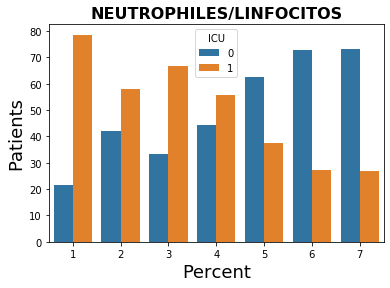

<Figure size 864x432 with 0 Axes>

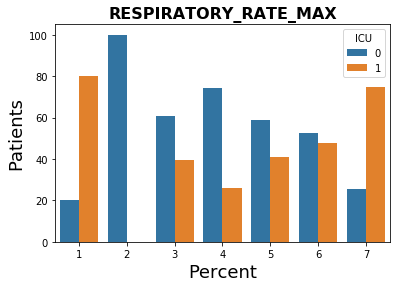

<Figure size 864x432 with 0 Axes>

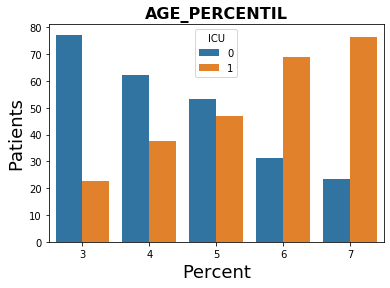

<Figure size 864x432 with 0 Axes>

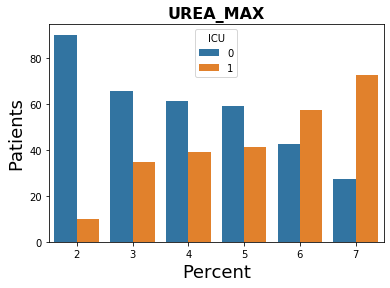

<Figure size 864x432 with 0 Axes>

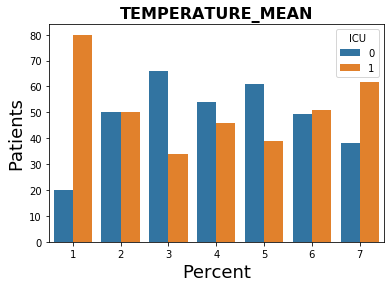

<Figure size 864x432 with 0 Axes>

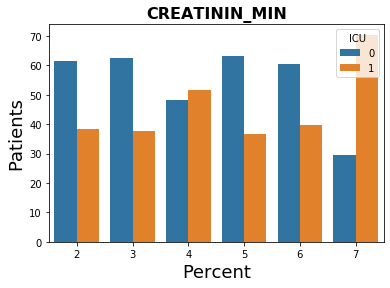

In [33]:
n_splits = 8
for ind in fi_df['VARIAVEL'][:6]:
    dados_limpos_red['feature_pct'] = classifica_intervalo(dados_limpos_red[ind].to_list(),n_splits)
    df_agrupado = dados_limpos_red.groupby(['feature_pct','ICU']).count()[ind].reset_index()
    df_agrupado["perc"] = df_agrupado[ind]/df_agrupado.groupby(['feature_pct'])[ind].transform('sum').round(1)*100
    plt.figure(figsize=(12,6))
     
    fig, ax = plt.subplots()
    sns.barplot(data=df_agrupado, x="feature_pct", y='perc', hue="ICU")  
    ax.set_title(ind, fontsize=16, fontweight="bold")
    ax.set_xlabel("Percent", fontsize=18)  
    ax.set_ylabel("Patients", fontsize=18)
    ax;

dados_limpos_red.drop(['feature_pct'], axis = 1, inplace = True)


In [34]:
### Agrupando idades semelhantes
#
dict_AGE = {
    10: 1,
    20: 1,
    30: 1,
    40: 1,
    50: 2,
    60: 2,
    70: 2,
    80: 3,
    90: 3,
    100:3
}
#
dados_limpos_red['AGE_AGRUPADO'] = dados_limpos_red['AGE_PERCENTIL'].map(dict_AGE)
dados_limpos_red = dados_limpos_red.drop("AGE_ABOVE65", axis = 1)

inclui_agrupamento(dados_limpos_red,'CREATININ_MIN', 10,False)

,,UREA_MAX,TTPA_MAX,TGP_MIN,TGO_MIN,TEMPERATURE_MEAN,SODIUM_MEDIAN,SAT02_VENOUS_MEDIAN,SAT02_ARTERIAL_MAX,RESPIRATORY_RATE_MAX,POTASSIUM_MEDIAN,...,BLAST_MEDIAN,BILLIRUBIN_MEDIAN,ALBUMIN_MEDIAN,AGE_PERCENTIL,GENDER,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_ARTERIAL_MEAN,NEUTROPHILES/LINFOCITOS,AGE_AGRUPADO,CREATININ_MIN_PERCENTIL
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,
0,0,-0.836145,-0.825613,-0.990854,-0.997201,-0.285714,-0.028571,0.345679,0.939394,-0.636364,-0.518519,...,-1.0,-0.938950,0.605263,60,0,0.086420,-0.019310,0.949515,2,8
2,10,-0.836145,-0.846633,-0.986662,-0.995428,0.357143,0.085714,0.345679,0.939394,-0.575758,-0.703704,...,-1.0,-0.938950,0.605263,10,0,-0.489712,-0.554965,0.454450,1,5
3,15,-0.937349,-0.846633,-0.956555,-0.989549,-0.285714,0.200000,0.580247,0.939394,-0.515152,-0.777778,...,-1.0,-0.972789,-0.263158,40,1,0.012346,-0.114846,0.938541,1,2
4,20,-0.903614,-0.846633,-0.991235,-0.998507,0.285714,0.142857,0.345679,0.939394,-0.575758,-0.592593,...,-1.0,-0.935113,0.605263,10,0,0.333333,0.170940,1.267746,1,5
5,25,-0.884337,-0.846633,-0.988948,-0.997947,-0.196429,0.085714,0.345679,0.939394,-0.575758,-0.666667,...,-1.0,-0.938950,0.605263,10,0,-0.037037,-0.204179,2.487410,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,1900,-0.860241,-0.629428,-0.981326,-0.925725,0.142857,-0.428571,0.345679,0.939394,-0.515152,-0.629630,...,-1.0,-0.293564,-0.578947,40,1,-0.160494,-0.337765,0.851571,1,4
381,1905,-0.855422,-0.846633,-0.995808,-0.998507,-0.059524,-0.314286,0.345679,0.939394,-0.515152,-0.518519,...,-1.0,-0.938950,0.605263,100,0,-0.407407,-0.502374,0.905741,3,7
382,1910,-0.787952,-0.846633,-0.986662,-0.995428,-0.071429,-0.085714,0.345679,0.939394,-0.515152,-0.407407,...,-1.0,-0.938950,0.605263,50,0,0.012346,-0.119975,0.894205,2,6


In [35]:
## Generating a baseline model to see how our changes are improving

## RF
modelo_random_forrest = RandomForestClassifier(n_estimators = 200)
print("Random Forrest")
media, std, auc_val = roda_modelo_cv(modelo_random_forrest, dados_limpos_red, 10, 30)

## Regressão Logística

print("Regressão Logística")
modelo_reg_log = LogisticRegression(max_iter=10000)
media,std, auc_val = roda_modelo_cv(modelo_reg_log, dados_limpos_red, 10, 30)

## Gradient Boosting

print("Gradient Boosting")
modelo_gboost = GradientBoostingClassifier(n_estimators = 200)
media, std, auc_val = roda_modelo_cv(modelo_gboost, dados_limpos_red, 10, 30)

Random Forrest
-----------------------------------------------------------
O roc auc score do modelo é: 0.8072 ± 0.0865
O roc auc score do conjunto de validação é: 0.7884
-----------------------------------------------------------
Regressão Logística
-----------------------------------------------------------
O roc auc score do modelo é: 0.7393 ± 0.0946
O roc auc score do conjunto de validação é: 0.695
-----------------------------------------------------------
Gradient Boosting
-----------------------------------------------------------
O roc auc score do modelo é: 0.7923 ± 0.091
O roc auc score do conjunto de validação é: 0.7447
-----------------------------------------------------------


In [36]:
espaco_de_parametros = {
    "n_estimators" : [200],
    "max_depth" : [None, 3,4],
    "criterion" : ["gini", "entropy"],
    "max_features" : ["sqrt", "log2"],
    "bootstrap" : [True],
    "min_samples_split" : [2,3,4,5,6,7,8,9,10,12,16,20],
    "min_samples_leaf" : [1,2,3,4,5,6,7]
}


In [37]:
resultados, tempo_percorrido = roda_random_search(dados_limpos, 10,15,75)

In [38]:
display(resultados.head(7))
print("O randomsearch levou", round(tempo_percorrido/60,1), " minutos.")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,...,split143_test_score,split144_test_score,split145_test_score,split146_test_score,split147_test_score,split148_test_score,split149_test_score,mean_test_score,std_test_score,rank_test_score
0,0.340065,0.013754,0.018297,0.005971,200,4,2,log2,None,entropy,...,0.802632,0.881579,0.894737,0.789474,0.700658,0.868421,0.871711,0.823310,0.069072,1
1,0.320565,0.020626,0.018885,0.006537,200,8,1,log2,None,gini,...,0.832237,0.858553,0.871711,0.782895,0.730263,0.851974,0.848684,0.822920,0.072851,2
2,0.460262,0.018606,0.022647,0.003455,200,2,2,sqrt,None,entropy,...,0.776316,0.894737,0.898026,0.792763,0.720395,0.838816,0.855263,0.822320,0.070212,3
3,0.393891,0.033185,0.022908,0.007012,200,12,2,log2,None,gini,...,0.812500,0.855263,0.894737,0.782895,0.703947,0.865132,0.838816,0.822181,0.073102,4
4,0.434623,0.019845,0.022727,0.003159,200,2,2,log2,None,entropy,...,0.812500,0.878289,0.894737,0.812500,0.700658,0.842105,0.848684,0.821951,0.070605,5
5,0.320966,0.013392,0.017742,0.005520,200,16,1,sqrt,None,gini,...,0.812500,0.884868,0.884868,0.786184,0.710526,0.858553,0.855263,0.821895,0.072646,6
6,0.351033,0.020327,0.017980,0.005550,200,2,1,log2,None,entropy,...,0.807566,0.878289,0.898026,0.791118,0.731908,0.855263,0.847039,0.821418,0.071296,7


O randomsearch levou 69.6  minutos.


In [39]:
list_par = resultados.params[:5]

In [40]:
## RF
i = 1
for par in list_par:
    print("Conjunto ", i, ":")
    modelo_random_forrest = RandomForestClassifier(**par)
    print(par)
    media, std,auc_val = roda_modelo_cv(modelo_random_forrest, dados_limpos_red, 10, 30)
    i=i+1

Conjunto  1 :
{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True}
-----------------------------------------------------------
O roc auc score do modelo é: 0.8103 ± 0.0854
O roc auc score do conjunto de validação é: 0.768
-----------------------------------------------------------
Conjunto  2 :
{'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None, 'criterion': 'gini', 'bootstrap': True}
-----------------------------------------------------------
O roc auc score do modelo é: 0.8065 ± 0.0865
O roc auc score do conjunto de validação é: 0.7796
-----------------------------------------------------------
Conjunto  3 :
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True}
-----------------------------------------------------------
O roc

In [41]:
best_par = list_par[0]
print("""O modelo escolhido foi o do conjunto 1, pois apresentou uma melhora significativa no roc auc score
em relação ao anterior, sem ter o resultado no conjunto de validação muito reduzido. 
Os hiperparâmetros são os seguintes: \n""", best_par)

modelo_random_forrest = RandomForestClassifier(**best_par)
print("\n Resultado do modelo:")
media, std, auc_val = roda_modelo_cv(modelo_random_forrest, dados_limpos_red, 10, 30,True)

O modelo escolhido foi o do conjunto 1, pois apresentou uma melhora significativa no roc auc score
em relação ao anterior, sem ter o resultado no conjunto de validação muito reduzido. 
Os hiperparâmetros são os seguintes: 
 {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True}

 Resultado do modelo:
-----------------------------------------------------------
All Scores:
Acuracy: 0.7318
Recall: 0.6768
Precision: 0.7359
F1-Score: 0.6951
O roc auc score do modelo é: 0.8103 ± 0.0854
O roc auc score do conjunto de validação é: 0.768
-----------------------------------------------------------


### Conclusão do Desafio Extra:

Mesmo desconsiderando muitos exames considerados mais complexos, o resultado obtido pelo modelo 2 foi excelente, e muito próximo ao modelo principal (Roc Auc 0.81 vs 0.813 do modelo 1). <br>
Isso é bastante animador, pois indica que podem ser feitas ótimas previsões mesmo em locais com menos recursos.